# 🛰️ EuroSAT Challenge (RGB Bands Only) 🌍


Welcome, Earth Explorer! 🌱

Your mission — is to **build the lightest, fastest, most accurate model** ...well, at least for classifying **10 satellite land cover classes** from the **EuroSAT RGB** dataset. 🎯

---

** Objective **:  
🏋️‍♂️ Make it *lightweight*.  
🎯 Make it *accurate*.  
🚀 Make it *awesome*.

---

Forget GPS — you’ll train your model to **spot roads, forests, and urban jungles** just from above.

---

❓ **ISSUES?**  
Check the sacred scrolls of PyTorch:  
👉 [https://pytorch.org/docs/stable/index.html](https://pytorch.org/docs/stable/index.html)

---

💡 HINT: ResNet? Maybe. MobileNet? Possibly. TinyNet? Who knows?!  
👾 Better if your model fits (MB) on a CubeSat satellite.


Epoch 1/5 - Train Loss: 1.6282, Train Acc: 0.4429, Val Loss: 1.3822, Val Acc: 0.5254, Time: 19.42s


Epoch 2/5 - Train Loss: 1.3227, Train Acc: 0.5461, Val Loss: 1.2336, Val Acc: 0.5757, Time: 19.87s


Epoch 3/5 - Train Loss: 1.2332, Train Acc: 0.5733, Val Loss: 1.1738, Val Acc: 0.5946, Time: 21.13s


Epoch 4/5 - Train Loss: 1.1833, Train Acc: 0.5842, Val Loss: 1.1429, Val Acc: 0.6004, Time: 19.17s


Epoch 5/5 - Train Loss: 1.1508, Train Acc: 0.5987, Val Loss: 1.1085, Val Acc: 0.6028, Time: 19.32s


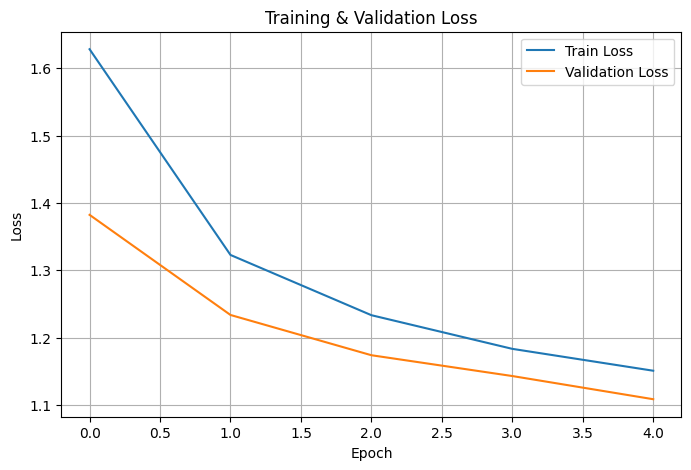


🕒 Inference time on test set: 10.31 seconds
⏱️  Avg. inference time per image: 3.82 ms
Test Accuracy: 0.5948148148148148

Classification Report:
              precision    recall  f1-score   support

           0     0.7137    0.4865    0.5786       333
           1     0.7965    0.8654    0.8295       312
           2     0.3289    0.6599    0.4390       297
           3     0.4697    0.1170    0.1873       265
           4     0.8068    0.9025    0.8520       236
           5     0.6604    0.6829    0.6715       205
           6     0.4206    0.2335    0.3003       227
           7     0.6204    0.7204    0.6667       279
           8     0.4222    0.4488    0.4351       254
           9     0.8188    0.7740    0.7958       292

    accuracy                         0.5948      2700
   macro avg     0.6058    0.5891    0.5756      2700
weighted avg     0.6107    0.5948    0.5805      2700



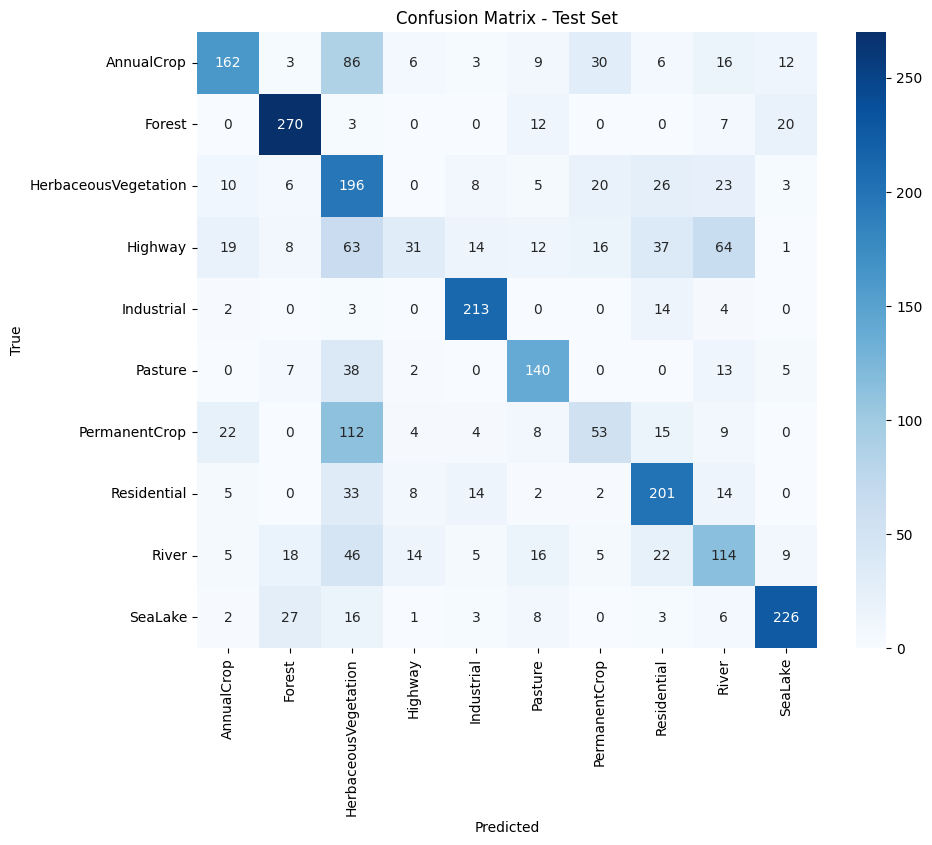

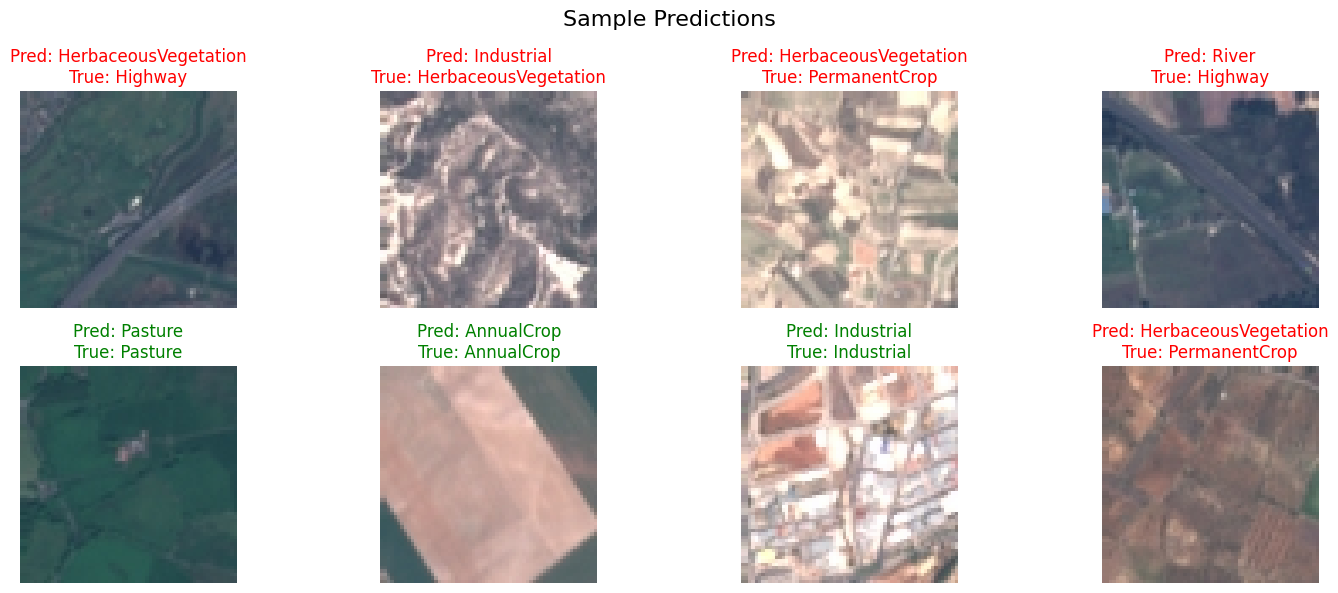

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, models, transforms
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random
from tqdm import tqdm
import time

# Set random seed for reproducibility
seed = 0
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# Define data transformations (resize, convert to tensor, normalize)
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize input images to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225])   # ImageNet std
])

# Load EuroSAT RGB dataset with transforms applied
dataset = datasets.EuroSAT(root='./data', download=True, transform=transform)

# Split dataset: 70% train, 20% validation, 10% test
train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size],
                                                        generator=torch.Generator().manual_seed(seed))

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)
test_loader = DataLoader(test_dataset, batch_size=1)  # For inference timing

# Load a ResNet18 model without pretrained weights
model = models.resnet18(weights=None)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final classification layer with a new one (10 output classes)
model.fc = nn.Linear(model.fc.in_features, 10)

# Send model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training and validation function
def train_model(num_epochs=3, log_file="train_log.txt"):
    train_losses = []
    val_losses = []
    accuracies = []

    # Create a log file to record losses and accuracy
    with open(log_file, "w") as f:
        f.write("Epoch,Train_Loss,Val_Loss,Val_Accuracy\n")

        for epoch in range(num_epochs):
            model.train()
            running_loss = 0.0
            correct_train = 0
            total_train = 0
            start_time = time.time()

            # Train on batches
            loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_train += (preds == labels).sum().item()
                total_train += labels.size(0)

                loop.set_postfix(loss=loss.item())

            # Compute train metrics
            train_loss = running_loss / len(train_loader)
            train_acc = correct_train / total_train
            train_losses.append(train_loss)

            # Validation phase
            model.eval()
            val_loss = 0.0
            correct_val = 0
            total_val = 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    correct_val += (preds == labels).sum().item()
                    total_val += labels.size(0)

            # Compute validation metrics
            val_loss /= len(val_loader)
            val_acc = correct_val / total_val
            val_losses.append(val_loss)
            accuracies.append(val_acc)

            end_time = time.time()

            # Print and log metrics
            print(f"Epoch {epoch+1}/{num_epochs} - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, "
                  f"Time: {end_time - start_time:.2f}s")

            f.write(f"{epoch+1},{train_loss:.4f},{val_loss:.4f},{val_acc:.4f}\n")

    return train_losses, val_losses

# Start training
train_losses, val_losses = train_model(num_epochs=5)

# Plot training and validation loss curves
plt.figure(figsize=(8, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')
plt.grid(True)
plt.show()

# Evaluate model on test set
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_labels = []
    all_images = []

    start_time = time.time()  # Start inference timing

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_images.extend(inputs.cpu())

    end_time = time.time()  # End inference timing

    # Compute inference time
    total_time = end_time - start_time
    num_samples = len(all_preds)
    time_per_image = total_time / num_samples

    print(f"\n🕒 Inference time on test set: {total_time:.2f} seconds")
    print(f"⏱️  Avg. inference time per image: {time_per_image*1000:.2f} ms")

    return np.array(all_labels), np.array(all_preds), all_images

# Run evaluation and get predictions
y_true, y_pred, images = evaluate_model(test_loader)

# Print evaluation metrics
print("Test Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.show()

# Show a few sample predictions with true and predicted labels
def show_sample_predictions(images, y_true, y_pred, class_names, n=8):
    plt.figure(figsize=(15, 6))
    for i in range(n):
        img = images[i].permute(1, 2, 0).numpy()
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # De-normalize
        img = np.clip(img, 0, 1)

        plt.subplot(2, n//2, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"Pred: {class_names[y_pred[i]]}\nTrue: {class_names[y_true[i]]}",
                  color="green" if y_true[i]==y_pred[i] else "red")
    plt.suptitle("Sample Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

# Display sample predictions
show_sample_predictions(images, y_true, y_pred, dataset.classes, n=8)